## Robust Mean - Variance Portfolio Optimization

Robust portfolio optimization is a variant of traditional portfolio optimization. The objective is to allocate a total investment amount across different assets to maximize the portfolio's expected return, while ensuring a very low probability (e.g., 0.5%) that the actual return falls below this expected value. This approach addresses the uncertainty inherent in portfolio returns, making it a robust optimization problem.

In the example taken from Bertsimas and Den Hertog (2015) [1], Section 3.4, we have n = 200 assets. Let $r_i$ denote the return of the $i$-th asset. The return on Asset #200 $r_{n}=1.05$ has zero variability. The returns of the remaining assets $r_i$, $\forall i \in [n - 1]$, are random variables taking values in the intervals $[\mu_i - \sigma_i ,\mu_i + \sigma_i  ]$. $\vec{\mu}$ and $\vec{\sigma}$ are defined as:

$$ \mu_i = 1.05 + \frac{0.3\left(n - i\right)}{n - 1} , \space \sigma_i = 0.05 + \frac{0.6\left(n - i\right)}{n - 1}, \space \forall i \in [n - 1] $$



To solve this problem, we first import the required packages and generate the data. 

In [23]:
import lropt
import cvxpy as cp
import numpy as np
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import SparseEfficiencyWarning
warnings.filterwarnings('ignore', category=UserWarning, module='cvxpy')
warnings.filterwarnings('ignore', category=SparseEfficiencyWarning)


In [24]:
N = 200
GUARANTEED_RETURN = 1.05
b2 = 0.3
b3 = 0.05
b4 = 0.6
P = 2
rho_values = np.linspace(0.1, 2.0, 10) 
names = ['ellipsoidal', 'budget']
num_scenarios = 100  # Number of scenarios for simulation
mu = np.zeros(N - 1)
for i in range(N - 1):
    mu_i = GUARANTEED_RETURN + b2 * (N - i) / (N- 1)
    mu[i] = mu_i  

sigma = np.zeros(N - 1)
for i in range(N - 1):
    sigma_i = b3 + b4 * (N - i) / (N - 1)
    sigma[i] = sigma_i 


The problem we want to solve is the uncertain linear optimization problem:

$$ 
\begin{aligned}
& \text{maximize} \quad t\\
& \text{subject to} \quad \mu^T x + \sigma^T x + 1.05x_{n-1} \geq t , \\
& 1^T x= 1, \\
& x \geq 0
\end{aligned}
$$

$ x_i $ is the capital to be invested in asset $i$. The guarenteed yearly return is 1.05.



In this problem, the uncertain data are the retuns $r_i = \mu_i + \sigma_i z_i, i \in [199]$ where $z_i, i\in[199]$, are independant random variables with zero mean varying in the segments $[-1, 1]$. The robust counterpart to the uncertain linear optimization problem is:


$$ 
\begin{aligned}
& \text{maximize} \quad t\\
& \text{subject to} \quad (\mu + \sigma^T z)^Tx + 1.05x_{n-1} \geq t , \quad \forall z \in \mathcal{Z}, \\
& 1^Tx= 1, \\
& x \geq 0
\end{aligned}
$$

for a variety of uncertainty sets $ \mathcal{Z} $. 

In the following snippet, we solve this problem using  Ellipsoidal, Box and Budget uncertainty sets and compare the results.


In [25]:
results = []


for rho in rho_values:
    uncertainty_sets = [
        lropt.Ellipsoidal(rho=rho, a=np.diag(sigma), b=mu),
        lropt.Budget(rho1=rho, rho2=rho, b=mu, a=np.diag(sigma))
    ]
    
    for uc_index, uc in enumerate(uncertainty_sets):
        t = cp.Variable()
        x = cp.Variable(N, nonneg=True)
        z = lropt.UncertainParameter(N - 1, uncertainty_set=uc)

        constraints = [
            z @ x[:(N-1)] + GUARANTEED_RETURN * x[-1] >= t,
            cp.sum(x) == 1
        ]

        objective = cp.Maximize(t)
        prob = lropt.RobustProblem(objective, constraints)
        prob.solve()

        optimal_allocation = x.value
        optimal_return = float(t.value)


        simulated_returns = []
        simulated_risks = []
        for _ in range(num_scenarios):

            simulated_return = np.dot(optimal_allocation[:(N-1)], mu) + GUARANTEED_RETURN * optimal_allocation[-1]
            cov_matrix = np.diag(sigma ** 2)
            simulated_variance = np.dot(optimal_allocation[:(N-1)].T, np.dot(cov_matrix, optimal_allocation[:(N-1)]))
            simulated_risk = np.sqrt(simulated_variance)
            
            simulated_returns.append(simulated_return)
            simulated_risks.append(simulated_risk)
        
        avg_return = np.mean(simulated_returns)
        avg_risk = np.mean(simulated_risks)

        results.append({
            'rho': rho,
            'uncertainty_set': names[uc_index],
            'return': avg_return,
            'risk': avg_risk
        })

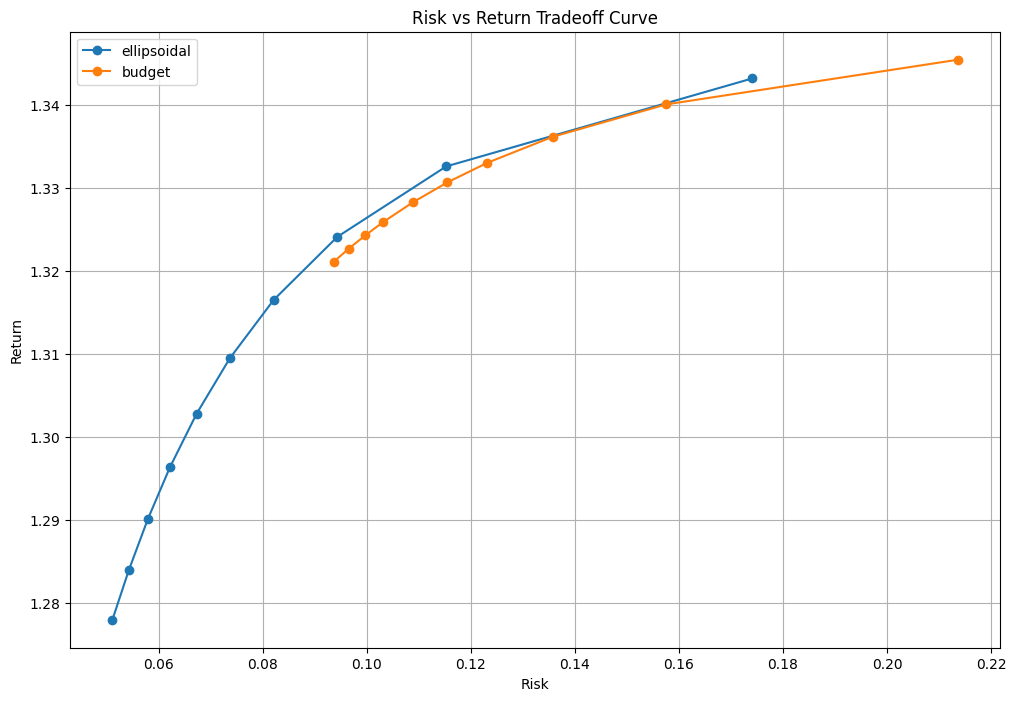

In [26]:
df_results = pd.DataFrame(results)
plt.figure(figsize=(12, 8))

for name in names:
    subset = df_results[df_results['uncertainty_set'] == name]
    plt.plot(subset['risk'], subset['return'], marker='o', label=name)

plt.xlabel('Risk')
plt.ylabel('Return')
plt.title('Risk vs Return Tradeoff Curve')
plt.legend()
plt.grid(True)
plt.show()

# References

1. Bertsimas, Dimitris, and Dick Den Hertog. Robust and Adaptive Optimization. [Dynamic Ideas LLC], 2022.